<a href="https://colab.research.google.com/github/Alexsam14/dogs_vs_cats_vs_wild-faces-/blob/main/cat_or_dog_or_wild(faces_lol).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets --upgrade
import opendatasets as od
url = 'https://www.kaggle.com/datasets/andrewmvd/animal-faces'
od.download(url)

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


100%|██████████| 696M/696M [00:03<00:00, 198MB/s] 


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import torch
from torchvision import transforms
from torch import nn
from torch.utils.data import Dataset, DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
base_dir = '/content/animal-faces/afhq'
image_paths = []
labels = []

for dir in os.listdir(base_dir):
  for label in os.listdir(f"{base_dir}/{dir}"):
    for image in os.listdir(f"{base_dir}/{dir}/{label}"):
      image_paths.append(f"{base_dir}/{dir}/{label}/{image}")
      labels.append(label)

data_frame = pd.DataFrame({'image_path' : image_paths, 'label' : labels})
data_frame.head()

,image_path,label
0,/content/animal-faces/afhq/train/cat/pixabay_c...,cat
1,/content/animal-faces/afhq/train/cat/pixabay_c...,cat
2,/content/animal-faces/afhq/train/cat/pixabay_c...,cat
3,/content/animal-faces/afhq/train/cat/pixabay_c...,cat
4,/content/animal-faces/afhq/train/cat/pixabay_c...,cat


In [ ]:
df_train = data_frame.sample(frac=0.8)
df_val = data_frame.drop(df_train.index)
df_test = df_val.sample(frac=0.5)
df_val = df_val.drop(df_test.index)

print(f"Train size : {len(df_train)}")
print(f"Validation size : {len(df_val)}")
print(f"Test size : {len(df_test)}")

Train size : 12904
Validation size : 1613
Test size : 1613


In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(df_train['label'])

transforms = transforms.Compose([
    transforms.Resize((124,124)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32)
    ])

class CustomDataset(Dataset):
  def __init__(self, dataframe, transforms=None):
    super().__init__()
    self.dataframe = dataframe
    self.labels = torch.tensor(label_encoder.transform(dataframe['label'])).to(device)
    self.transforms = transforms

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, idx):
    image_path = self.dataframe.iloc[idx, 0]
    image = Image.open(image_path)

    if self.transforms:
      image_tensor = self.transforms(image).to(device)

    label = self.labels[idx]
    return image_tensor, label

train_dataset = CustomDataset(df_train, transforms)
test_dataset = CustomDataset(df_test, transforms)
val_dataset = CustomDataset(df_val, transforms)

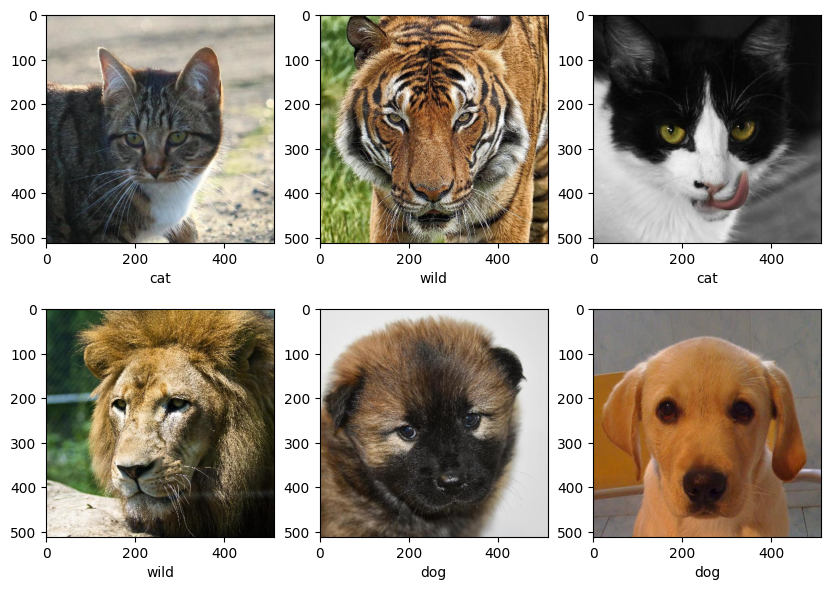

In [ ]:
nrows=2
ncolumns=3

fig, ax = plt.subplots(nrows, ncolumns, figsize=(10,7))

for i in range(nrows):
  for j in range(ncolumns):
    animal = data_frame.sample(1)
    image_path = animal['image_path'].iloc[0]
    label = animal['label'].iloc[0]
    image = Image.open(image_path)
    ax[i][j].imshow(image)
    ax[i][j].set_xlabel(label)
plt.show()

In [ ]:
batch_size = 16

train_data = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_data = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_data = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(2,2)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(64*31*31, 64)
    self.fc2 = nn.Linear(64, 3)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    x = self.conv1(x) #--> (32, 124, 124)
    x = self.pool(x) #--> (32, 62, 62)
    x = self.relu(x)
    x = self.conv2(x) #--> (64, 62, 62)
    x = self.pool(x) #--> (64, 31, 31)
    x = self.relu(x)
    x = self.dropout(self.flatten(x))
    x = self.dropout(self.fc1(x))
    x = self.relu(x)
    x = self.fc2(x)
    return x

In [ ]:
from torchsummary import summary

model = Network().to(device)
summary(model, (3, 124, 124))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 124, 124]             896
         MaxPool2d-2           [-1, 32, 62, 62]               0
              ReLU-3           [-1, 32, 62, 62]               0
            Conv2d-4           [-1, 64, 62, 62]          18,496
         MaxPool2d-5           [-1, 64, 31, 31]               0
              ReLU-6           [-1, 64, 31, 31]               0
           Flatten-7                [-1, 61504]               0
           Dropout-8                [-1, 61504]               0
            Linear-9                   [-1, 64]       3,936,320
          Dropout-10                   [-1, 64]               0
             ReLU-11                   [-1, 64]               0
           Linear-12                    [-1, 3]             195
Total params: 3,955,907
Trainable params: 3,955,907
Non-trainable params: 0
---------------------------

In [ ]:
total_training_acc_plot = []
total_training_loss_plot = []
total_val_acc_plot = []
total_val_loss_plot = []

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 7

for epoch in range(epochs):
  training_loss = 0.0
  training_acc = 0.0
  val_acc = 0.0
  val_loss = 0.0

  model.train()
  for images, labels in train_data:
    optimizer.zero_grad()
    output = model(images)
    loss = criterion(output, labels)

    loss.backward()
    optimizer.step()

    training_loss += loss.item()
    training_acc += (output.argmax(dim=1) == labels).sum().item()

  total_training_loss_plot.append(round(training_loss/1000, 4))
  total_training_acc_plot.append(round((training_acc/len(train_dataset)) * 100, 4))

  model.eval()
  with torch.no_grad():
    for images, labels in val_data:
      output = model(images)
      loss = criterion(output, labels)
      val_loss += loss.item()
      val_acc += (output.argmax(dim=1) == labels).sum().item()

  total_val_loss_plot.append(round(val_loss/1000, 4))
  total_val_acc_plot.append(round((val_acc/len(val_dataset)) * 100, 4))

  print(f"Epochs {epoch+1}/{epochs}   Training loss: {training_loss/1000 : .4f}   Training accuracy: {(training_acc/len(train_dataset)) * 100 : .4f}"
                                    f"Validation loss: {val_loss/1000 : .4f}   Validation accuracy: {(val_acc/len(val_dataset)) * 100 : .4f}")

Epochs 1/7   Training loss:  0.3805   Training accuracy:  80.7657Validation loss:  0.0391   Validation accuracy:  85.1209
Epochs 2/7   Training loss:  0.1840   Training accuracy:  91.5995Validation loss:  0.0158   Validation accuracy:  93.8004
Epochs 3/7   Training loss:  0.1171   Training accuracy:  94.6993Validation loss:  0.0189   Validation accuracy:  93.8624
Epochs 4/7   Training loss:  0.0819   Training accuracy:  96.1407Validation loss:  0.0168   Validation accuracy:  93.8004
Epochs 5/7   Training loss:  0.0597   Training accuracy:  97.2722Validation loss:  0.0125   Validation accuracy:  95.6603


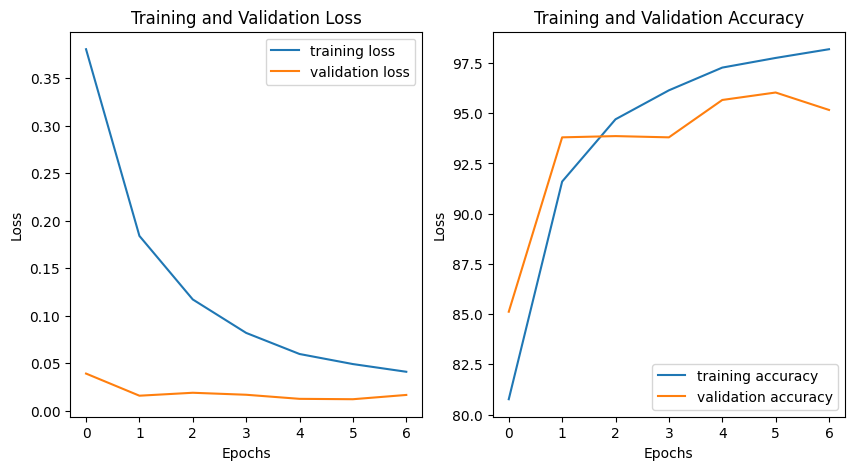

In [ ]:
nrows=1
ncols=2
fig, ax = plt.subplots(nrows, ncols, figsize=(10,5))


ax[0].plot(total_training_loss_plot, label='training loss')
ax[0].plot(total_val_loss_plot, label = 'validation loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and Validation Loss')
ax[0].legend()

ax[1].plot(total_training_acc_plot, label='training accuracy')
ax[1].plot(total_val_acc_plot, label = 'validation accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_title('Training and Validation Accuracy')
ax[1].legend()

plt.show()

In [18]:
def inference(image_path):
  image = Image.open(image_path)
  image_tensor = transforms(image).unsqueeze(0).to(device)
  output = model(image_tensor)
  prediction = torch.argmax(output, dim=1).item()
  return label_encoder.inverse_transform([prediction])

In [20]:
print(inference('/content/pexels-alena-koval-233944-982300.jpg'))

['cat']
